<a href="https://colab.research.google.com/github/jhzhang07/CAS783/blob/master/COMPAS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/content/drive/MyDrive/CAS783/')
PROJECT_PATH = "/content/drive/MyDrive/CAS783/"

In [ ]:
!pip3 install --upgrade pip

In [ ]:
!pip3 install -r "/content/drive/MyDrive/CAS783/requirements.txt"

In [ ]:

from adversarial_models import *
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap
from copy import deepcopy

In [ ]:
class racist_model_f:
    def predict(self, X):
        return np.array([params.negative_outcome if x[race_indc] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X):
        return one_hot_encode(self.predict(X))

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

class innocuous_model_psi:
    def predict_proba(self, X):
        return one_hot_encode(np.array([params.negative_outcome if x[unrelated_indcs] > 0 else params.positive_outcome for x in X]))

class innocuous_model_psi_two:
    def predict_proba(self, X):
        A = np.where(X[:, unrelated_indcs] > 0, params.positive_outcome, params.negative_outcome)
        B = np.where(X[:, unrelated_indcs1] > 0, params.positive_outcome, params.negative_outcome)
        preds = np.logical_xor(A, B).astype(int)
        return one_hot_encode(preds)

def experiment_main():
    params = Params("/content/drive/MyDrive/CAS783/model_configurations/experiment_params.json")
    np.random.seed(params.seed)
    X, y, cols = get_and_preprocess_compas_data(params)

    X['unrelated_column_one'] = np.random.choice([0, 1], size=X.shape[0])
    X['unrelated_column_two'] = np.random.choice([0, 1], size=X.shape[0])

    features = [c for c in X]
    race_indc = features.index('race')
    unrelated_indcs = features.index('unrelated_column_one')
    unrelated_indcs1 = features.index('unrelated_column_two')
    X = X.values

    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1)
    ss = StandardScaler().fit(xtrain)
    xtrain = ss.transform(xtrain)
    xtest = ss.transform(xtest)

    print('=====================')
    print("Starting LIME experiments on COMPAS dataset...")
    print('=====================')

    adv_lime = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi()).train(
        xtrain, ytrain,
        categorical_features=[features.index('unrelated_column_one'), features.index('unrelated_column_two'), features.index('c_charge_degree_F'), features.index('c_charge_degree_M'), features.index('two_year_recid'), features.index('race'), features.index("sex_Male"), features.index("sex_Female")],
        feature_names=features, perturbation_multiplier=30)

    adv_explainer = lime.lime_tabular.LimeTabularExplainer(
        xtrain, sample_around_instance=True, feature_names=adv_lime.get_column_names(),
        categorical_features=[features.index('unrelated_column_one'), features.index('unrelated_column_two'), features.index('c_charge_degree_F'), features.index('c_charge_degree_M'), features.index('two_year_recid'), features.index('race'), features.index("sex_Male"), features.index("sex_Female")],
        discretize_continuous=False)

    explanations = [adv_explainer.explain_instance(xtest[i], adv_lime.predict_proba).as_list() for i in range(xtest.shape[0])]

    print("\n[ LIME Results - Single Unrelated Column ]")
    print(experiment_summary(explanations, features))
    print("Model Fidelity:", round(adv_lime.fidelity(xtest), 2))

    adv_lime = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi_two()).train(
        xtrain, ytrain,
        categorical_features=[features.index('unrelated_column_one'), features.index('unrelated_column_two'), features.index('c_charge_degree_F'), features.index('c_charge_degree_M'), features.index('two_year_recid'), features.index('race'), features.index("sex_Male"), features.index("sex_Female")],
        feature_names=features, perturbation_multiplier=30)

    adv_explainer = lime.lime_tabular.LimeTabularExplainer(
        xtrain, feature_names=adv_lime.get_column_names(),
        categorical_features=[features.index('unrelated_column_one'), features.index('unrelated_column_two'), features.index('c_charge_degree_F'), features.index('c_charge_degree_M'), features.index('two_year_recid'), features.index('race'), features.index("sex_Male"), features.index("sex_Female")],
        discretize_continuous=False)

    explanations = [adv_explainer.explain_instance(xtest[i], adv_lime.predict_proba).as_list() for i in range(xtest.shape[0])]

    print("\n[ LIME Results - Two Unrelated Columns ]")
    print(experiment_summary(explanations, features))
    print("Model Fidelity:", round(adv_lime.fidelity(xtest), 2))

    print('=====================')
    print("Launching SHAP evaluation...")
    print('=====================')

    background_distribution = shap.kmeans(xtrain, 10)

    adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).train(
        xtrain, ytrain, feature_names=features)

    adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
    explanations = adv_kerenel_explainer.shap_values(xtest)

    formatted_explanations = [[(features[i], exp[i]) for i in range(len(exp))] for exp in explanations]

    print("\n[ SHAP Results - Single Unrelated Column ]")
    print(experiment_summary(formatted_explanations, features))
    print("Model Fidelity:", round(adv_shap.fidelity(xtest), 2))

    background_distribution = shap.kmeans(xtrain, 10)

    adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi_two()).train(
        xtrain, ytrain, feature_names=features)

    adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
    explanations = adv_kerenel_explainer.shap_values(xtest)

    formatted_explanations = [[(features[i], exp[i]) for i in range(len(exp))] for exp in explanations]

    print("\n[ SHAP Results - Two Unrelated Columns ]")
    print(experiment_summary(formatted_explanations, features))
    print("Model Fidelity:", round(adv_shap.fidelity(xtest), 2))

if __name__ == "__main__":
    experiment_main()

Starting LIME experiments on COMPAS dataset...

[ LIME Results - Single Unrelated Column ]
{1: [(np.str_('unrelated_column_one'), np.float64(1.0))], 2: [(np.str_('c_charge_degree_F'), np.float64(0.10679611650485436)), (np.str_('c_charge_degree_M'), np.float64(0.11488673139158576)), (np.str_('length_of_stay'), np.float64(0.006472491909385114)), (np.str_('priors_count'), np.float64(0.008090614886731391)), (np.str_('race'), np.float64(0.22006472491909385)), (np.str_('sex_Female'), np.float64(0.1650485436893204)), (np.str_('sex_Male'), np.float64(0.16990291262135923)), (np.str_('two_year_recid'), np.float64(0.11326860841423948)), (np.str_('unrelated_column_two'), np.float64(0.09546925566343042))], 3: [(np.str_('age'), np.float64(0.014563106796116505)), (np.str_('c_charge_degree_F'), np.float64(0.12297734627831715)), (np.str_('c_charge_degree_M'), np.float64(0.11974110032362459)), (np.str_('length_of_stay'), np.float64(0.014563106796116505)), (np.str_('priors_count'), np.float64(0.019417475

  0%|          | 0/618 [00:00<?, ?it/s]


[ SHAP Results - Single Unrelated Column ]
{1: [(np.str_('age'), np.float64(0.0048543689320388345)), (np.str_('length_of_stay'), np.float64(0.06957928802588997)), (np.str_('unrelated_column_one'), np.float64(0.9255663430420712))], 2: [(np.str_('age'), np.float64(0.06310679611650485)), (np.str_('c_charge_degree_M'), np.float64(0.0016181229773462784)), (np.str_('length_of_stay'), np.float64(0.3155339805825243)), (np.str_('priors_count'), np.float64(0.05825242718446602)), (np.str_('race'), np.float64(0.45792880258899676)), (np.str_('two_year_recid'), np.float64(0.021035598705501618)), (np.str_('unrelated_column_one'), np.float64(0.0744336569579288)), (np.str_('unrelated_column_two'), np.float64(0.008090614886731391))], 3: [(np.str_('age'), np.float64(0.24919093851132687)), (np.str_('c_charge_degree_F'), np.float64(0.008090614886731391)), (np.str_('c_charge_degree_M'), np.float64(0.0048543689320388345)), (np.str_('length_of_stay'), np.float64(0.2977346278317152)), (np.str_('priors_count')

  0%|          | 0/618 [00:00<?, ?it/s]


[ SHAP Results - Two Unrelated Columns ]
{1: [(np.str_('age'), np.float64(0.03398058252427184)), (np.str_('length_of_stay'), np.float64(0.24433656957928804)), (np.str_('priors_count'), np.float64(0.038834951456310676)), (np.str_('race'), np.float64(0.2669902912621359)), (np.str_('unrelated_column_one'), np.float64(0.1796116504854369)), (np.str_('unrelated_column_two'), np.float64(0.23624595469255663))], 2: [(np.str_('age'), np.float64(0.05501618122977346)), (np.str_('c_charge_degree_M'), np.float64(0.003236245954692557)), (np.str_('length_of_stay'), np.float64(0.06310679611650485)), (np.str_('priors_count'), np.float64(0.032362459546925564)), (np.str_('race'), np.float64(0.28802588996763756)), (np.str_('sex_Male'), np.float64(0.0016181229773462784)), (np.str_('unrelated_column_one'), np.float64(0.2766990291262136)), (np.str_('unrelated_column_two'), np.float64(0.27993527508090615))], 3: [(np.str_('age'), np.float64(0.05501618122977346)), (np.str_('c_charge_degree_F'), np.float64(0.011

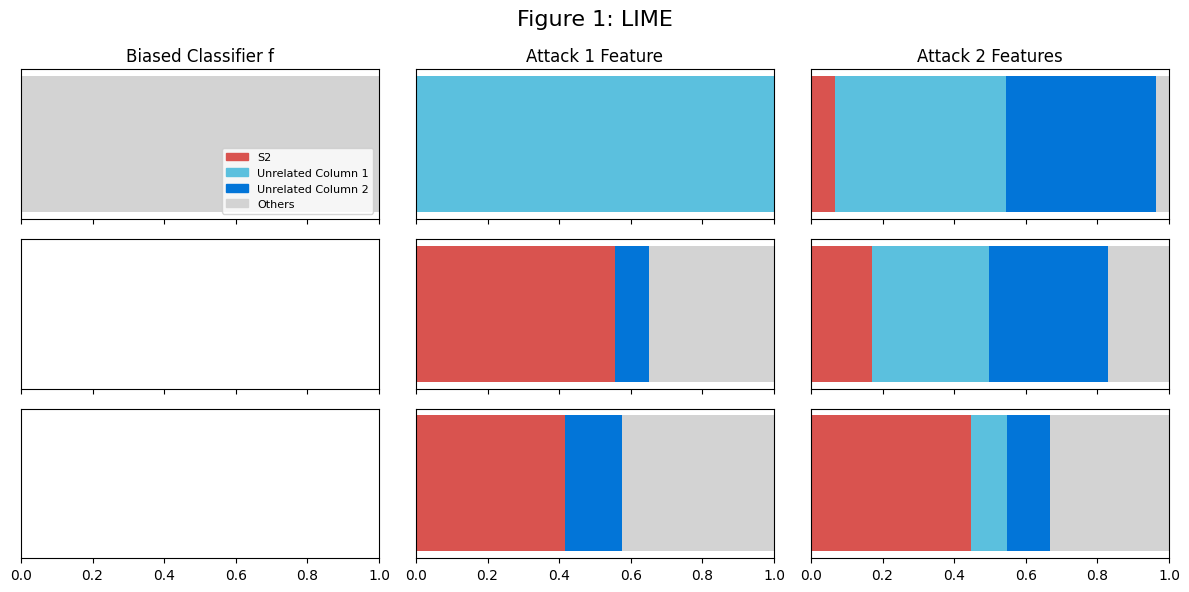

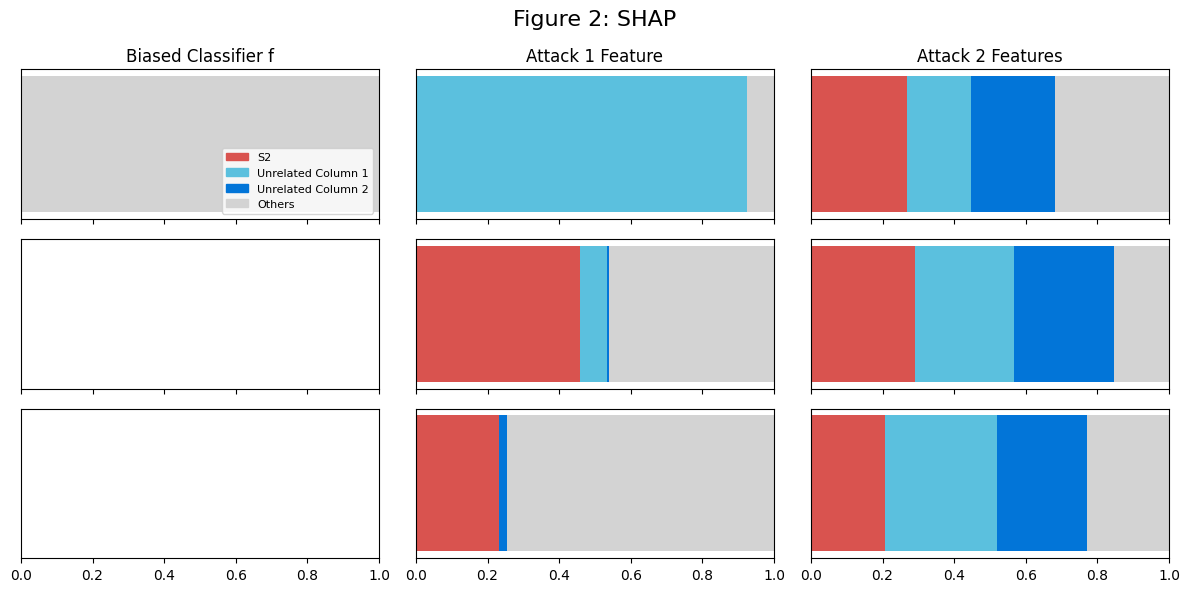

In [25]:
import matplotlib.pyplot as plt
import numpy as np

lime_one_feature = {
    1: {'unrelated_column_one': 1.0},
    2: {
        'c_charge_degree_F': 0.10679611650485436,
        'c_charge_degree_M': 0.11488673139158576,
        'length_of_stay': 0.006472491909385114,
        'priors_count': 0.008090614886731391,
        'race': 0.22006472491909385,
        'sex_Female': 0.1650485436893204,
        'sex_Male': 0.16990291262135923,
        'two_year_recid': 0.11326860841423948,
        'unrelated_column_two': 0.09546925566343042
    },
    3: {
        'age': 0.014563106796116505,
        'c_charge_degree_F': 0.12297734627831715,
        'c_charge_degree_M': 0.11974110032362459,
        'length_of_stay': 0.014563106796116505,
        'priors_count': 0.019417475728155338,
        'race': 0.2297734627831715,
        'sex_Female': 0.10517799352750809,
        'sex_Male': 0.0825242718446602,
        'two_year_recid': 0.1343042071197411,
        'unrelated_column_two': 0.156957928802589
    }
}

lime_two_features = {
    1: {
        'c_charge_degree_F': 0.012944983818770227,
        'c_charge_degree_M': 0.008090614886731391,
        'length_of_stay': 0.0048543689320388345,
        'race': 0.011326860841423949,
        'sex_Female': 0.01779935275080906,
        'sex_Male': 0.0372168284789644,
        'two_year_recid': 0.009708737864077669,
        'unrelated_column_one': 0.4773462783171521,
        'unrelated_column_two': 0.42071197411003236
    },
    2: {
        'age': 0.003236245954692557,
        'c_charge_degree_F': 0.05339805825242718,
        'c_charge_degree_M': 0.06796116504854369,
        'priors_count': 0.006472491909385114,
        'race': 0.04692556634304207,
        'sex_Female': 0.06796116504854369,
        'sex_Male': 0.05501618122977346,
        'two_year_recid': 0.038834951456310676,
        'unrelated_column_one': 0.3284789644012945,
        'unrelated_column_two': 0.33171521035598706
    },
    3: {
        'age': 0.008090614886731391,
        'c_charge_degree_F': 0.09061488673139159,
        'c_charge_degree_M': 0.10194174757281553,
        'length_of_stay': 0.0048543689320388345,
        'priors_count': 0.014563106796116505,
        'race': 0.10679611650485436,
        'sex_Female': 0.18932038834951456,
        'sex_Male': 0.15048543689320387,
        'two_year_recid': 0.11165048543689321,
        'unrelated_column_one': 0.10194174757281553,
        'unrelated_column_two': 0.11974110032362459
    }
}

shap_one_feature = {
    1: {
        'age': 0.0048543689320388345,
        'length_of_stay': 0.06957928802588997,
        'unrelated_column_one': 0.9255663430420712
    },
    2: {
        'age': 0.06310679611650485,
        'c_charge_degree_M': 0.0016181229773462784,
        'length_of_stay': 0.3155339805825243,
        'priors_count': 0.05825242718446602,
        'race': 0.45792880258899676,
        'two_year_recid': 0.021035598705501618,
        'unrelated_column_one': 0.0744336569579288,
        'unrelated_column_two': 0.008090614886731391
    },
    3: {
        'age': 0.24919093851132687,
        'c_charge_degree_F': 0.008090614886731391,
        'c_charge_degree_M': 0.0048543689320388345,
        'length_of_stay': 0.2977346278317152,
        'priors_count': 0.16181229773462782,
        'race': 0.2087378640776699,
        'sex_Female': 0.014563106796116505,
        'sex_Male': 0.009708737864077669,
        'two_year_recid': 0.022653721682847898,
        'unrelated_column_two': 0.022653721682847898
    }
}

shap_two_features = {
    1: {
        'age': 0.03398058252427184,
        'length_of_stay': 0.24433656957928804,
        'priors_count': 0.038834951456310676,
        'race': 0.2669902912621359,
        'unrelated_column_one': 0.1796116504854369,
        'unrelated_column_two': 0.23624595469255663
    },
    2: {
        'age': 0.05501618122977346,
        'c_charge_degree_M': 0.003236245954692557,
        'length_of_stay': 0.06310679611650485,
        'priors_count': 0.032362459546925564,
        'race': 0.28802588996763756,
        'sex_Male': 0.0016181229773462784,
        'unrelated_column_one': 0.2766990291262136,
        'unrelated_column_two': 0.27993527508090615
    },
    3: {
        'age': 0.05501618122977346,
        'c_charge_degree_F': 0.011326860841423949,
        'c_charge_degree_M': 0.0016181229773462784,
        'length_of_stay': 0.09223300970873786,
        'priors_count': 0.043689320388349516,
        'race': 0.1941747572815534,
        'sex_Female': 0.0048543689320388345,
        'sex_Male': 0.008090614886731391,
        'two_year_recid': 0.024271844660194174,
        'unrelated_column_one': 0.3122977346278317,
        'unrelated_column_two': 0.2524271844660194
    }
}

colors = {
    'S2': '#D9534F',
    'Unrelated1': '#5BC0DE',
    'Unrelated2': '#0275D8',
    'Others': '#D3D3D3'
}

def plot_attack(axs, results, method_name):
    titles = ['Biased Classifier f', 'Attack 1 Feature', 'Attack 2 Features']
    datasets = [results['biased'], results['attack1'], results['attack2']]
    for idx, data in enumerate(datasets):
        for rank in [1, 2, 3]:
            ax = axs[rank-1, idx]
            vals = data[rank]
            s2 = 0
            unrelated1 = 0
            unrelated2 = 0
            others = 0
            for feat, pct in vals.items():
                if feat == 'race' or feat == 'sex_Female' or feat == 'sex_Male':
                    s2 += pct
                elif feat == 'unrelated_column_one':
                    unrelated1 += pct
                elif feat == 'unrelated_column_two':
                    unrelated2 += pct
                else:
                    others += pct
            ax.barh(0, s2, color=colors['S2'])
            ax.barh(0, unrelated1, left=s2, color=colors['Unrelated1'])
            ax.barh(0, unrelated2, left=s2+unrelated1, color=colors['Unrelated2'])
            ax.barh(0, others, left=s2+unrelated1+unrelated2, color=colors['Others'])
            ax.set_xlim(0, 1)
            ax.set_yticks([])
            if rank == 1:
                ax.set_title(titles[idx])
    for ax in axs.flat:
        ax.label_outer()

fig, axs = plt.subplots(3, 3, figsize=(12, 6))
lime_results = {
    'biased': {1: {'S2': 1.0}, 2: {}, 3: {}},
    'attack1': lime_one_feature,
    'attack2': lime_two_features
}
plot_attack(axs, lime_results, "LIME")
handles = [
    plt.Rectangle((0,0),1,1, color=colors['S2'], label='S2'),
    plt.Rectangle((0,0),1,1, color=colors['Unrelated1'], label='Unrelated Column 1'),
    plt.Rectangle((0,0),1,1, color=colors['Unrelated2'], label='Unrelated Column 2'),
    plt.Rectangle((0,0),1,1, color=colors['Others'], label='Others')
]
axs[0,0].legend(handles=handles, loc='lower right', fontsize=8)
plt.suptitle("Figure 1: LIME", fontsize=16)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 3, figsize=(12, 6))
shap_results = {
    'biased': {1: {'S2': 1.0}, 2: {}, 3: {}},
    'attack1': shap_one_feature,
    'attack2': shap_two_features
}
plot_attack(axs, shap_results, "SHAP")
handles = [
    plt.Rectangle((0,0),1,1, color=colors['S2'], label='S2'),
    plt.Rectangle((0,0),1,1, color=colors['Unrelated1'], label='Unrelated Column 1'),
    plt.Rectangle((0,0),1,1, color=colors['Unrelated2'], label='Unrelated Column 2'),
    plt.Rectangle((0,0),1,1, color=colors['Others'], label='Others')
]
axs[0,0].legend(handles=handles, loc='lower right', fontsize=8)
plt.suptitle("Figure 2: SHAP", fontsize=16)
plt.tight_layout()
plt.show()
